In [1]:
# This is a very basic analysis of hyperparamters from a series of random searches run on
# the UNet2DS architecture in late June and early July 2017. For reference, the UNet2DS 
# architecture that scores 0.5356 on the test set had a Validation F1 Mean of ~0.86.
%matplotlib inline
import matplotlib.pyplot as plt
import json
import numpy as np
import os
from glob import glob

cpdirs = sorted(glob('../checkpoints/unet2ds_rs_0.*'))
cpdirs = [c for c in cpdirs if '0.00' not in c]
print('%d checkpoint directories with score >= 0.01' % len(cpdirs))

812 checkpoint directories with score >= 0.01


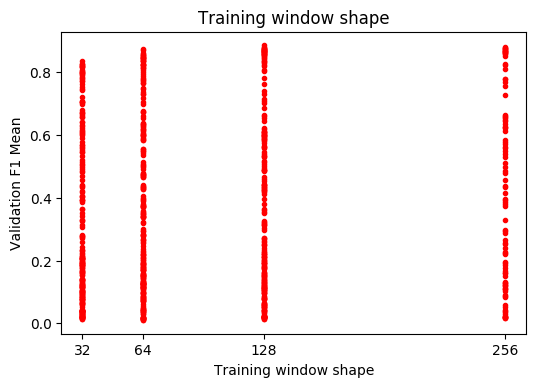

In [5]:
# Training window shape. Note all validation evaluations were done on 512x512.
x, y = [], []
for d in cpdirs:
    f = '%s/report.json' % d
    if not os.path.exists(f):
        continue
    fp = open(f)
    r = json.load(fp); fp.close()
    x.append(r['params']['wdw'])
    y.append(r['results']['val_nf_f1_mean'])
    plt.plot([x[-1]], [y[-1]], marker='o', markersize=3, color="red")
    
plt.xticks(sorted(np.unique(x)))
plt.title('Training window shape')
plt.ylabel('Validation F1 Mean')
plt.xlabel('Training window shape')
plt.show()

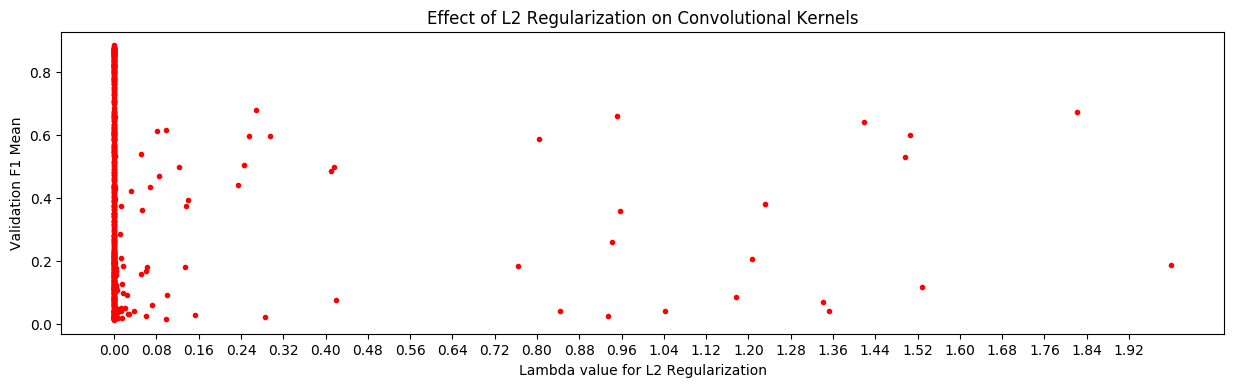

In [2]:
# L2 kernel regularization. Keras kernel regularizer applied to every convolutional layer.
plt.figure(figsize=(15,4))
for d in cpdirs:
    f = '%s/report.json' % d
    if not os.path.exists(f):
        continue
    fp = open(f)
    r = json.load(fp); fp.close()
    if r['params']['conv_l2_lambda'] > 2:
        continue
    x = r['params']['conv_l2_lambda']
    y = r['results']['val_nf_f1_mean']
    plt.plot([x], [y], marker='o', markersize=3, color="red")

plt.xticks([2.0 / 25. * n for n in range(25)])
plt.title('Effect of L2 Regularization on Convolutional Kernels')
plt.ylabel('Validation F1 Mean')
plt.xlabel('Lambda value for L2 Regularization')
plt.show()

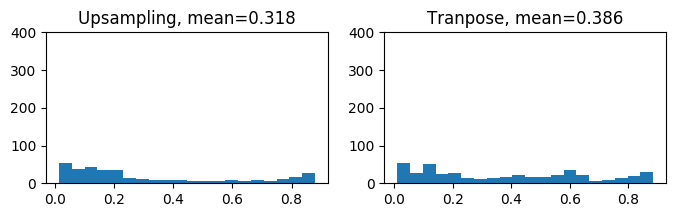

In [3]:
# 2D Upsampling vs. 2D Convolutional Transpose on the UNet upward pass.
transpose, upsampling = [], []

for d in cpdirs:
    f = '%s/report.json' % d
    if not os.path.exists(f):
        continue
    fp = open(f)
    r = json.load(fp); fp.close()
    if r['params']['upsampling_or_transpose'] == 'upsampling':
        upsampling.append(r['results']['val_nf_f1_mean'])
    else:
        transpose.append(r['results']['val_nf_f1_mean'])

fig, _ = plt.subplots(1,2, figsize=(8,2))
fig.axes[0].set_title('Upsampling, mean=%.3lf' % np.mean(upsampling))
fig.axes[0].hist(upsampling, 20)
fig.axes[0].set_ylim(0,400)
fig.axes[1].set_title('Tranpose, mean=%.3lf' % np.mean(transpose))
fig.axes[1].hist(transpose, 20)
fig.axes[1].set_ylim(0,400)
plt.show()

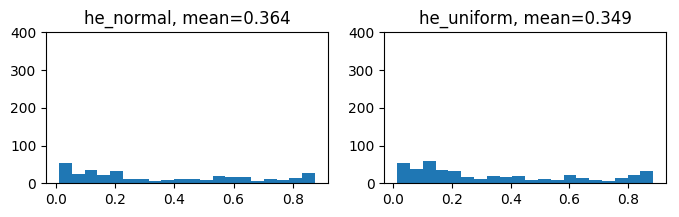

In [4]:
# Conv kernel initialization. He-normal vs. He-uniform. See the keras initializations documentation
# for details on the difference. He initialization is recommended when using ReLU activations in the network.
he_normal, he_uniform = [], []

for d in cpdirs:
    f = '%s/report.json' % d
    if not os.path.exists(f):
        continue
    fp = open(f)
    r = json.load(fp); fp.close()
    if r['params']['conv_kernel_init'] == 'he_normal':
        he_normal.append(r['results']['val_nf_f1_mean'])
    else:
        he_uniform.append(r['results']['val_nf_f1_mean'])

fig, _ = plt.subplots(1,2, figsize=(8,2))
fig.axes[0].set_title('he_normal, mean=%.3lf' % np.mean(he_normal))
fig.axes[0].hist(he_normal, 20)
fig.axes[0].set_ylim(0,400)
fig.axes[1].set_title('he_uniform, mean=%.3lf' % np.mean(he_uniform))
fig.axes[1].hist(he_uniform, 20)
fig.axes[1].set_ylim(0,400)
plt.show()

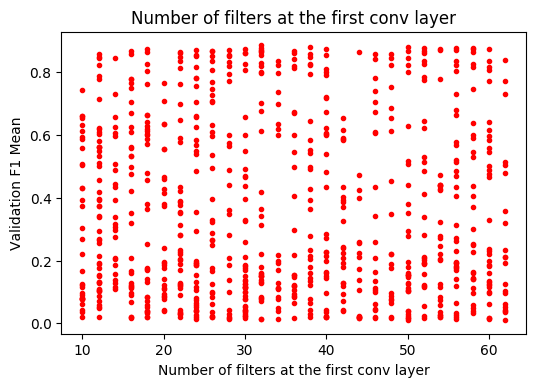

In [5]:
# Number of filters on the first layer - then gets doubled 4 times on the downward pass.
# e.g. base filters = 32 -> Conv(32), Conv(64), Conv(128), Conv(256), 
# Conv(512), Conv(256), Conv(128), Conv(64), Conv(32)
for d in cpdirs:
    f = '%s/report.json' % d
    if not os.path.exists(f):
        continue
    fp = open(f)
    r = json.load(fp); fp.close()
    x = r['params']['nb_filters_base']
    y = r['results']['val_nf_f1_mean']
    plt.plot([x], [y], marker='o', markersize=3, color="red")

plt.title('Number of filters at the first conv layer')
plt.ylabel('Validation F1 Mean')
plt.xlabel('Number of filters at the first conv layer')
plt.show()

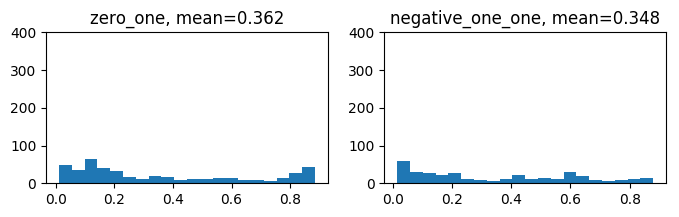

In [6]:
# Data pre-processing. Scaling to [0,1] vs. scaling to [-1,1].
zero_one, negative_one_one = [], []

for d in cpdirs:
    f = '%s/report.json' % d
    if not os.path.exists(f):
        continue
    fp = open(f)
    r = json.load(fp); fp.close()
    if 'preprocess' not in r['params'] or r['params']['preprocess'] == 'zero_one':
        zero_one.append(r['results']['val_nf_f1_mean'])
    else:
        negative_one_one.append(r['results']['val_nf_f1_mean'])

fig, _ = plt.subplots(1,2, figsize=(8,2))
fig.axes[0].set_title('zero_one, mean=%.3lf' % np.mean(zero_one))
fig.axes[0].hist(zero_one, 20)
fig.axes[0].set_ylim(0,400)
fig.axes[1].set_title('negative_one_one, mean=%.3lf' % np.mean(negative_one_one))
fig.axes[1].hist(negative_one_one, 20)
fig.axes[1].set_ylim(0,400)
plt.show()

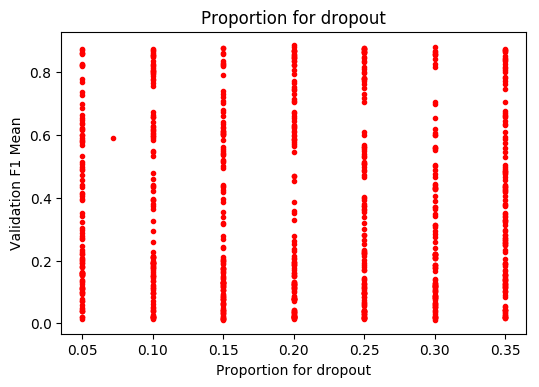

In [7]:
# Dropout proportion. The proportion p gets applied after the second conv block, 
# then 2*p after the 3rd, 4th, 5th, and 6th. Then p again after the next-to-last conv block.
for d in cpdirs:
    f = '%s/report.json' % d
    if not os.path.exists(f):
        continue
    fp = open(f)
    r = json.load(fp); fp.close()
    x = r['params']['prop_dropout_base']
    y = r['results']['val_nf_f1_mean']
    plt.plot([x], [y], marker='o', markersize=3, color="red")

plt.title('Proportion for dropout')
plt.ylabel('Validation F1 Mean')
plt.xlabel('Proportion for dropout')
plt.show()

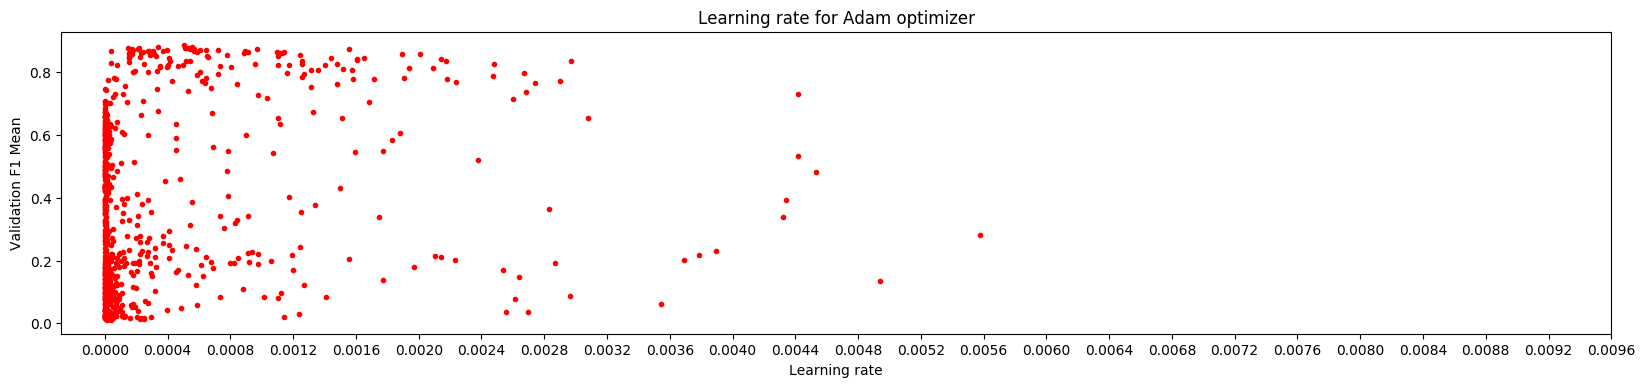

In [8]:
# Learning rate used with Adam optimizer.
plt.figure(figsize=(20, 4))
for d in cpdirs:
    f = '%s/report.json' % d
    if not os.path.exists(f):
        continue
    fp = open(f)
    r = json.load(fp); fp.close()
    x = r['params']['learning_rate']
    y = r['results']['val_nf_f1_mean']
    plt.plot([x], [y], marker='o', markersize=3, color="red")

plt.title('Learning rate for Adam optimizer')
plt.xticks([(0.01 - 0.000001) / 25 * n for n in range(25)])
plt.ylabel('Validation F1 Mean')
plt.xlabel('Learning rate')
plt.show()

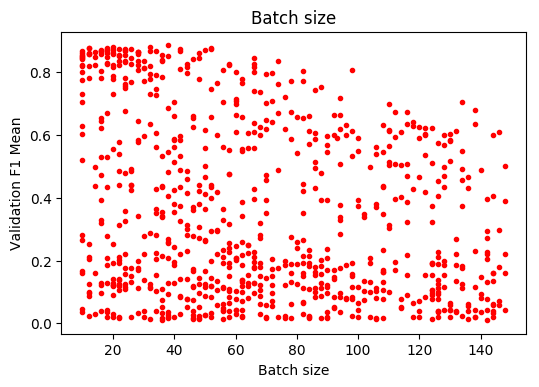

In [9]:
# Batch size.
for d in cpdirs:
    f = '%s/report.json' % d
    if not os.path.exists(f):
        continue
    fp = open(f)
    r = json.load(fp); fp.close()
    x = r['params']['batch_size']
    y = r['results']['val_nf_f1_mean']
    plt.plot([x], [y], marker='o', markersize=3, color="red")

plt.title('Batch size')
plt.ylabel('Validation F1 Mean')
plt.xlabel('Batch size')
plt.show()

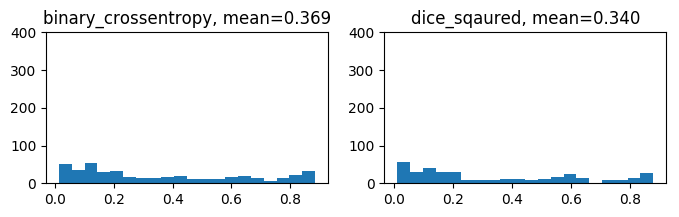

In [10]:
# Loss function - pixel-wise binary crossentropy vs. squared dice coefficient.
# Data pre-processing. Scaling to [0,1] vs. scaling to [-1,1].
binary_crossentropy, dice_sqaured = [], []

for d in cpdirs:
    f = '%s/report.json' % d
    if not os.path.exists(f):
        continue
    fp = open(f)
    r = json.load(fp); fp.close()
    if 'loss' not in r['params'] or r['params']['loss'] == 'binary_crossentropy':
        binary_crossentropy.append(r['results']['val_nf_f1_mean'])
    else:
        dice_sqaured.append(r['results']['val_nf_f1_mean'])

fig, _ = plt.subplots(1,2, figsize=(8,2))
fig.axes[0].set_title('binary_crossentropy, mean=%.3lf' % np.mean(binary_crossentropy))
fig.axes[0].hist(binary_crossentropy, 20)
fig.axes[0].set_ylim(0,400)
fig.axes[1].set_title('dice_sqaured, mean=%.3lf' % np.mean(dice_sqaured))
fig.axes[1].hist(dice_sqaured, 20)
fig.axes[1].set_ylim(0,400)
plt.show()